In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*1)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38817 instead
  warnings.warn(


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [12]:
client

<Client: 'tcp://10.148.0.106:57919' processes=0 threads=0, memory=0 B>

________________
### Read first: 
In this notebook, some basic information (e.g., bathymetry of the model domain, record-mean/max/min mixed layer depth, snapshots of u,v,w,b) are given in section 2. 

Section 3 displays some estimates based on the model output such as Rossby number, lateral buoyancy gradient, PV, Frontogenesis function. 

Raw outputs and 1-day low-pass filtered data are used in Section 3.

_________
# 1. Read dataset



In [6]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_B = xr.open_zarr(out_dir_zarr+'Buoy_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/22)
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...          ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) float32 ...
    rAs         (lat_g, lon) float32 ...
  * depth_left  (depth_left) float64 -0.035 1.035 2.18 ... 878.0 922.9 968.9
Data variables:
    U           (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1,

In [7]:
grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)

ds_KPP = xr.open_zarr(out_dir_zarr+'Surface_variable/KPPhbl_total_rechunk.zarr')
ds_Eta = xr.open_zarr(out_dir_zarr+'Surface_variable/Eta_total_rechunk.zarr')
ds_taux = xr.open_zarr(out_dir_zarr+'Surface_variable/oceTAUX_total_rechunk.zarr')
ds_tauy = xr.open_zarr(out_dir_zarr+'Surface_variable/oceTAUY_total_rechunk.zarr')
ds_fwflx = xr.open_zarr(out_dir_zarr+'Surface_variable/oceFWflx_total_rechunk.zarr')
ds_qnet = xr.open_zarr(out_dir_zarr+'Surface_variable/oceQnet_total_rechunk.zarr')
ds_qsw = xr.open_zarr(out_dir_zarr+'Surface_variable/oceQsw_total_rechunk.zarr')
ds_sflux = xr.open_zarr(out_dir_zarr+'Surface_variable/oceSflux_total_rechunk.zarr')

ds_surface = xr.merge([ds_KPP,ds_Eta,ds_taux,ds_tauy,ds_fwflx,ds_qnet,ds_qsw,ds_sflux,grid])

In [8]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic, boundary=None):
  * center   depth --> left
  * left     depth_left --> center


In [9]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')

In [10]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')

In [11]:
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_1day_lowpass_filter.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_1day_lowpass_filter.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_1day_lowpass_filter.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_zarr+'B_1day_lowpass_filter.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_filter = ds_filter.assign_coords(time=time_day) 
print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...            ...
    dxG           (lat_g, lon) float32 ...
    dyG           (lat, lon_g) float32 ...
    rA            (lat, lon) float32 ...
    rAz           (lat_g, lon_g) float32 ...
    rAw           (lat, lon_g) float32 ...
    rAs           (lat_g, lon) float32 ...
Data variables:
    U_low_filter  (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    V_l

# 2. Basics

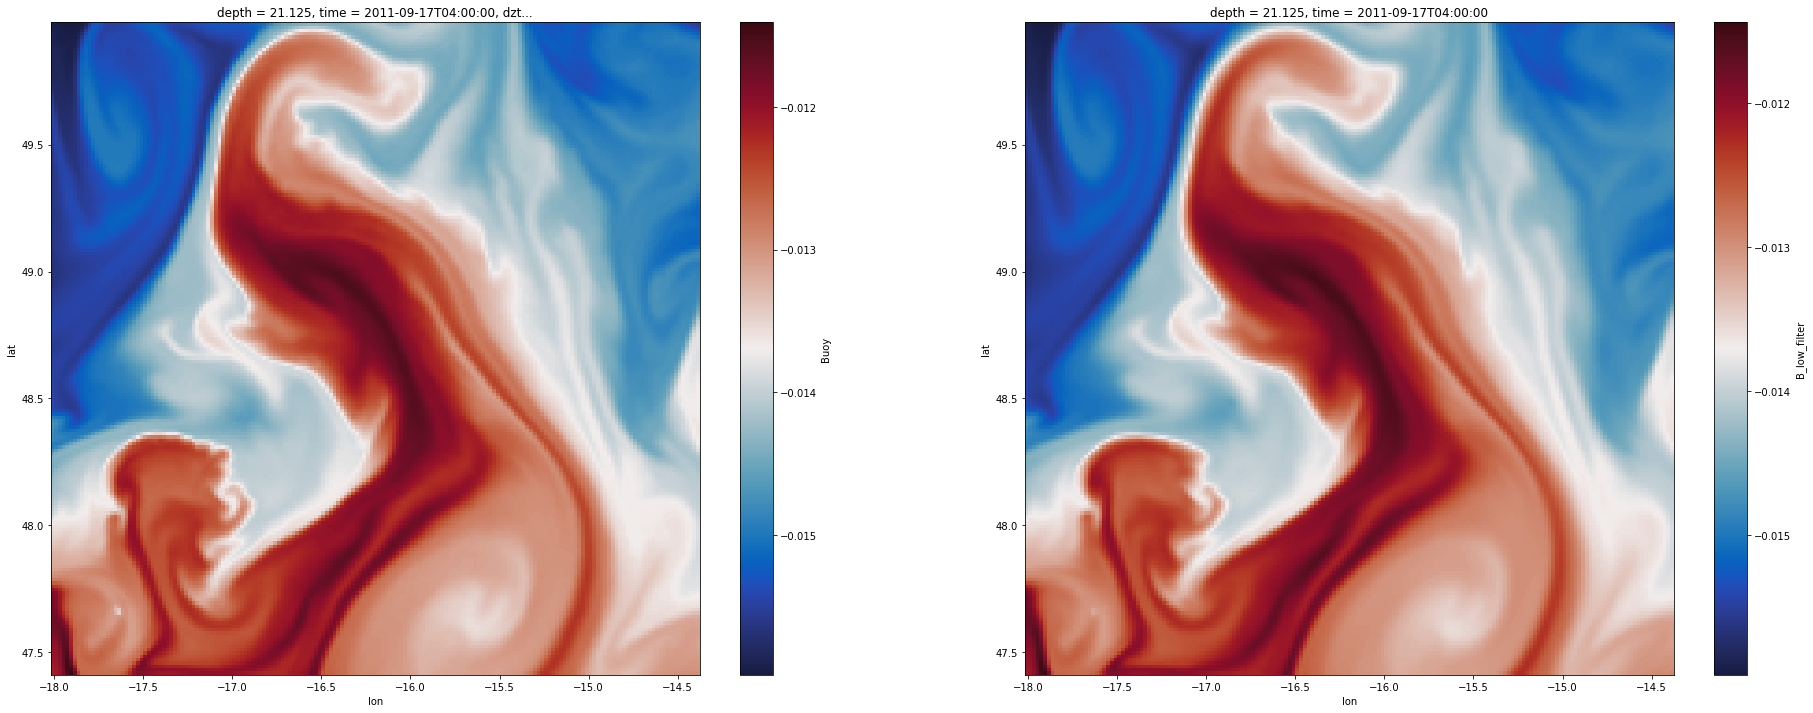

In [11]:
fig = plt.figure(figsize=(32,12))

plt.subplot(121)
ds.Buoy.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', cmap=cm.balance)

plt.subplot(122)
ds_filter.B_low_filter.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', cmap=cm.balance)

(500.0, 0.0)

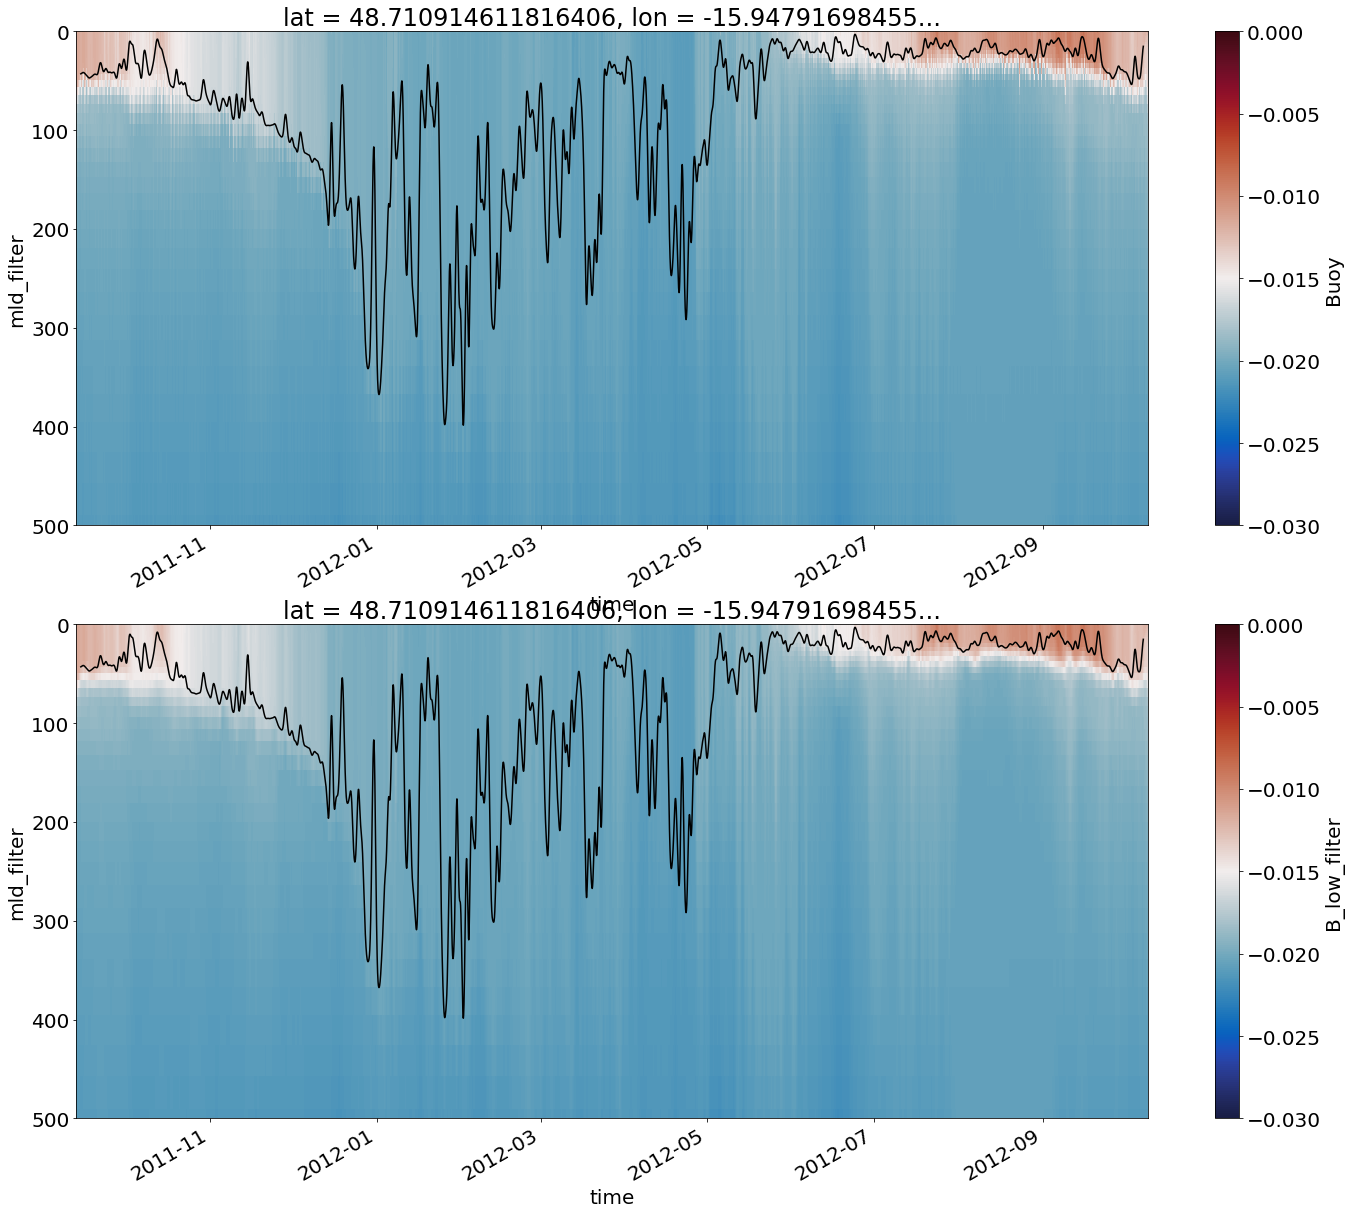

In [17]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(24,20))

ax = plt.subplot(211)
ds.Buoy.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.03, vmax=0.,cmap=cm.balance, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)
ax.set_ylim([500., 0.])

ax = plt.subplot(212)
ds_filter.B_low_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.03, vmax=0.,cmap=cm.balance, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)
ax.set_ylim([500., 0.])

TypeError: unsupported operand type(s) for *: 'int' and 'QuadMesh'

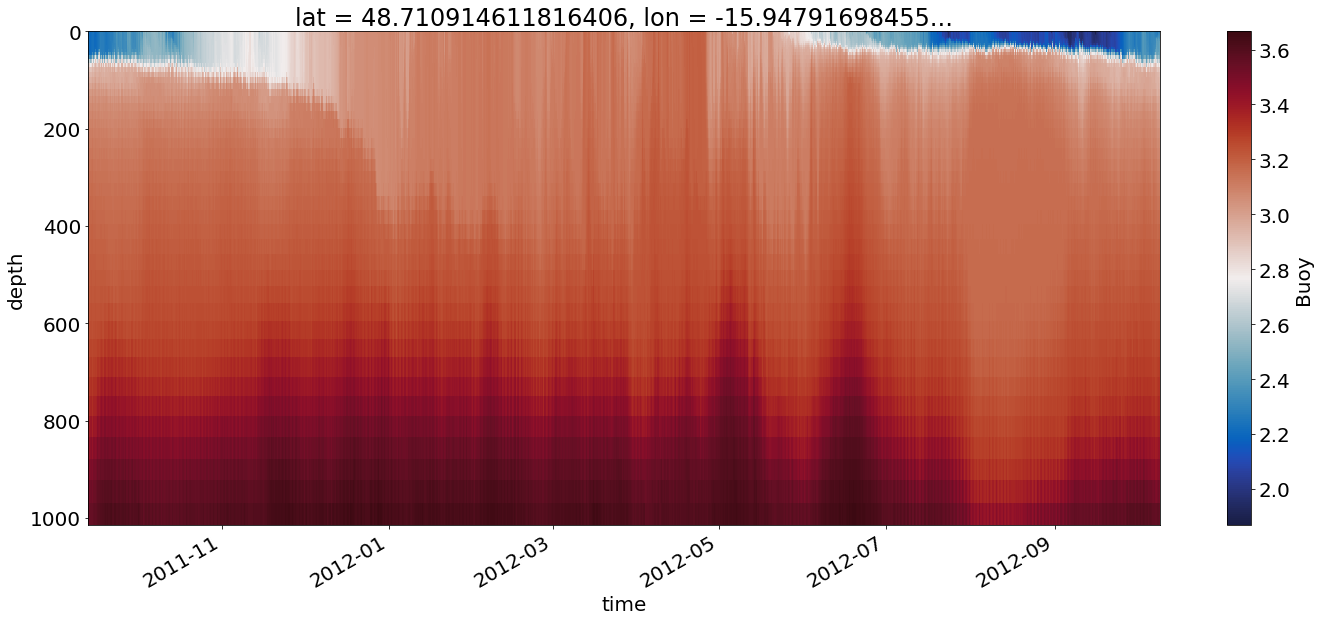

In [23]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(24,20))

ax = plt.subplot(211)
1025*(1-ds.Buoy.isel(lat=100,lon=100)*1025/9.8).plot(x='time', y='depth',cmap=cm.balance, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)
ax.set_ylim([500., 0.])



In [18]:
sh_raw = ds.Buoy.isel(lat=100,lon=100).cumsum(['depth'])/9.8
sh_filter = ds_filter.B_low_filter.isel(lat=100,lon=100).cumsum(['depth'])/9.8
sh_raw

<xarray.DataArray 'Buoy' (time: 9415, depth: 52)>
dask.array<truediv, shape=(9415, 52), dtype=float32, chunksize=(9415, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 48.71
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    lon      float64 -15.95
    XC       float32 ...
    YC       float32 ...
    CS       float32 ...
    SN       float32 ...
    Depth    float32 ...
    rA       float32 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 ... 43.74 44.88 46.06 46.06

(500.0, 0.0)

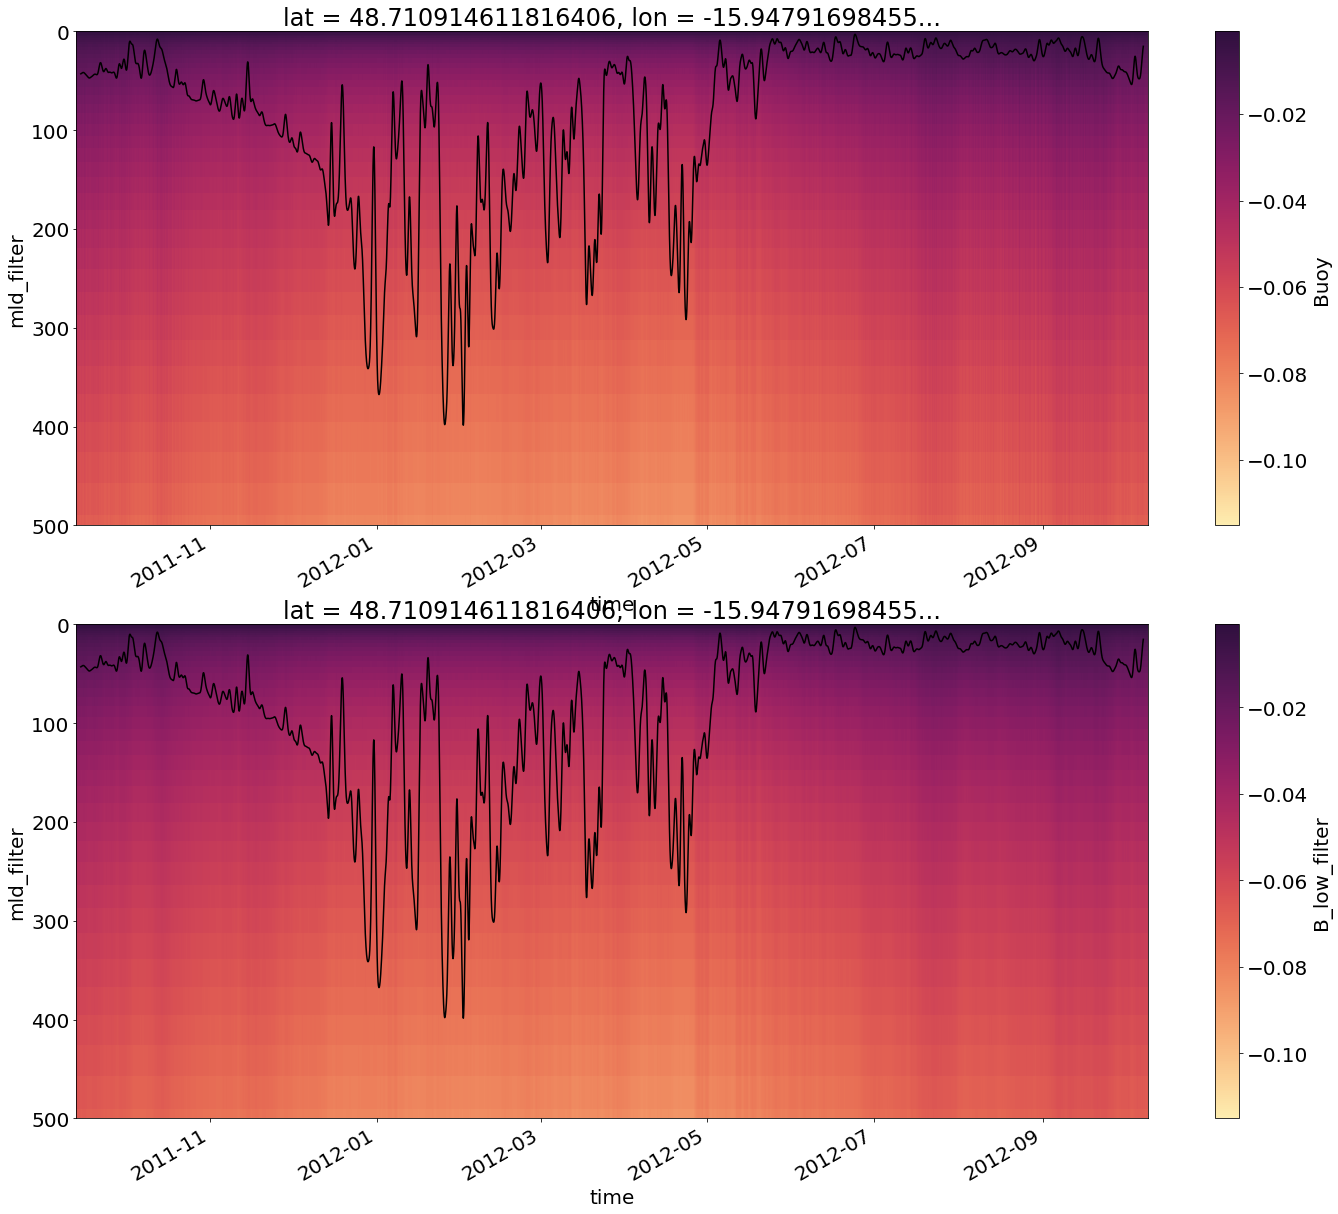

In [20]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(24,20))

ax = plt.subplot(211)
sh_raw.plot(x='time', y='depth',cmap=cm.matter, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)
ax.set_ylim([500., 0.])

ax = plt.subplot(212)
sh_filter.plot(x='time', y='depth',cmap=cm.matter, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)
ax.set_ylim([500., 0.])

In [14]:
sh_raw = ds.Buoy.isel(lat=100,lon=100)/9.8
sh_raw

<xarray.DataArray 'Buoy' (time: 9415, depth: 52)>
dask.array<truediv, shape=(9415, 52), dtype=float32, chunksize=(9415, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 48.71
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    lon      float64 -15.95
    XC       float32 ...
    YC       float32 ...
    CS       float32 ...
    SN       float32 ...
    Depth    float32 ...
    rA       float32 ...
    dzt      (depth) float64 1.07 1.145 1.308 1.495 ... 43.74 44.88 46.06 46.06

In [15]:
s = sh_raw.integrate("depth")
s

<xarray.DataArray 'Buoy' (time: 9415)>
dask.array<sum-aggregate, shape=(9415,), dtype=float64, chunksize=(9415,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 48.71
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
    lon      float64 -15.95
    XC       float32 -15.95
    YC       float32 48.71
    CS       float32 1.0
    SN       float32 -0.0
    Depth    float32 4.848e+03
    rA       float32 2.195e+06

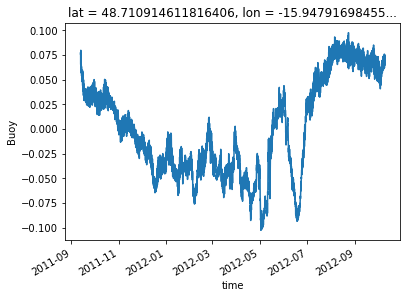

In [17]:
(s-s.mean()).plot()

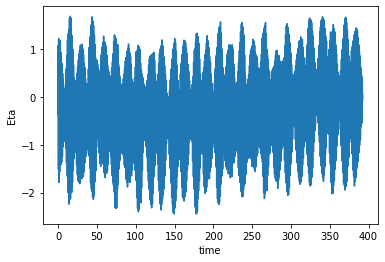

In [21]:
ds_Eta.Eta.isel(lat=100,lon=100).plot()

In [24]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
